# 0. Imports

In [1]:
import os
os.chdir("..")
import typing as tp

import albumentations as A
import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pytorch_lightning.loggers as loggers
import torch
import torch.nn as nn
import torch.optim as optim

from pathlib import Path

from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50 as DeepLab

from lib import encode_rle, get_dice, get_html

# 1. Data

## 1.1 Datasets

In [2]:
class TrainHumanDataset(Dataset):
    def __init__(
        self,
        data_path: Path,
        transform,
    ):
        self.image_paths = sorted([p for p in (data_path / 'train').glob('*')])
        self.mask_paths = sorted([p for p in (data_path / 'train_mask').glob('*')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx: int):
        image = cv2.imread(str(self.image_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)

        transformed = self.transform(image=image, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']
        
        return transformed_image, transformed_mask


class ValHumanDataset(Dataset):
    def __init__(
        self,
        data_path: Path,
        transform,
    ):
        self.image_paths = sorted([p for p in (data_path / 'valid').glob('*')])
        self.mask_paths = sorted([p for p in (data_path / 'valid_mask').glob('*')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx: int):
        image = cv2.imread(str(self.image_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)

        transformed = self.transform(image=image, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']
        
        return transformed_image, transformed_mask
    
    
class TestHumanDataset(Dataset):
    def __init__(
        self,
        data_path: Path,
        transform,
    ):
        self.image_paths = sorted([p for p in (data_path / 'test').glob('*')])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = cv2.imread(str(self.image_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        transformed = self.transform(image=image)
        transformed_image = transformed['image']

        return transformed_image

## 1.2. DataModule

In [3]:
class HumanDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = '/home/sergei/Downloads/MILTestTasks-task-human_segmentation/data',
        batch_size: int = 2,
        num_workers: int = 1,
    ):
        super().__init__()
        self.data_path = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        self.train_transform = A.Compose([
            A.RandomCrop(width=128, height=128),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        self.val_transform = A.Compose([
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
        self.test_transform = A.Compose([
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    def setup(self, stage: tp.Optional[str] = None):
        self.train_dataset = TrainHumanDataset(
            data_path=self.data_path,
            transform=self.train_transform,
        )
        self.val_dataset = ValHumanDataset(
            data_path=self.data_path,
            transform=self.val_transform,
        )
        self.test_dataset = TestHumanDataset(
            data_path=self.data_path,
            transform=self.test_transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            drop_last=True,
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=1,
        )

# 2. Model

In [4]:
class DeepLabSegmentor(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.deeplab = DeepLab(pretrained=True)
        for param in self.deeplab.backbone.parameters():
            param.requires_grad = False

        self.head = nn.Sequential(
            nn.Conv2d(in_channels=21, out_channels=1, kernel_size=1),
            nn.Sigmoid(),
        )

        self.criterion = nn.BCELoss()

    def forward(self, x):
        features = self.deeplab(x)['out']
        predicted_probs = self.head(features)

        return predicted_probs
    
    def training_step(self, batch, batch_idx: int):
        images, masks = batch
        predicted_probs = self.forward(images)
        predicted_probs = einops.rearrange(predicted_probs, 'bs 1 h w -> bs h w')
        loss = self.criterion(predicted_probs, masks / 255)

        self.log('train', {'loss': loss})

        return loss
    
    def validation_step(self, batch, batch_idx: int):
        images, masks = batch
        predicted_probs = self.forward(images)
        predicted_probs = einops.rearrange(predicted_probs, 'bs 1 h w -> bs h w')
        loss = self.criterion(predicted_probs, masks / 255)
        dice_loss = get_dice(
            torch.round(predicted_probs).cpu().numpy(),
            masks.cpu().numpy(),
        )
        
        self.log('val', {'loss': loss, 'dice_loss': dice_loss})
        
        return dice_loss
    
    def test_step(self, batch, batch_idx: int):
        if batch_idx == 0:
            self.result = list()

        images = batch
        predicted_probs = self.forward(images)
        predicted_probs = einops.rearrange(predicted_probs, 'bs 1 h w -> bs h w')
        predicted_mask = torch.round(predicted_probs)
        self.result.append(predicted_mask)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            factor=0.5,
            patience=4,
            verbose=True,
        )

        return {'optimizer': optimizer, 'scheduler': scheduler}

# 3. Loops

In [5]:
datamodule = HumanDataModule(
    batch_size=32,
    num_workers=8,
)
datamodule.setup()

In [6]:
model = DeepLabSegmentor()

In [12]:
logger = loggers.WandbLogger(project='human_segmentation')
logger.watch(model)

trainer = pl.Trainer(
    #overfit_batches=55,
    max_epochs=50,
    logger=logger,
    default_root_dir='/home/sergei/Downloads/MILTestTasks-task-human_segmentation',
    accelerator='gpu',
    devices=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


# 3.1. Train

In [13]:
trainer.fit(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | deeplab   | DeepLabV3  | 42.0 M
1 | head      | Sequential | 22    
2 | criterion | BCELoss    | 0     
-----------------------------------------
18.5 M    Trainable params
23.5 M    Non-trainable params
42.0 M    Total params
168.016   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/sergei/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# 3.2. Test

In [14]:
trainer.test(model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

In [15]:
ans = model.result

paths_to_imgs = sorted([str(p) for p in Path('/home/sergei/Downloads/MILTestTasks-task-human_segmentation/data/test').glob('*')])
pred_masks = [x.cpu().numpy()[0].astype(np.uint8) * 255 for x in ans]
_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/test3")

encoded_masks = [encode_rle(m) for m in pred_masks]
df = pd.DataFrame({'id': range(1460, 1560), 'rle_mask': encoded_masks})
df.to_csv('data/pred_test3.csv')

# Мысли

Не смог выделить на задание больше трёх часов. Сделал самое неприятное - поднял инфру обучения, осталось проверять гипотезы в рамках написанного кода, что довольно легко. Что сделано:
- взята архитектура DeepLabv3, обученная на COCO. Дообучаем её. Обучение быстрое, так что дообучаю целиком (одна голова обучается незначительно быстрее, но качество хуже)
- аугментации самые базовые
- графики с метриками тут: https://wandb.ai/sergevkim/human_segmentation

Что не успел сделать:
- поэкспериментировать с архитектурой сетки и вообще поподобирать гиперпараметры - хотя диплаб неплохой бэкбон, последние наработки на CVPR по сегментации в области unsupervised-semisupervised learning - типа попиксельного претренинга (эмбеды пикселей принадлежащие человеку похожи друг на друга и непохожи на эмбеды фона).
- поэкспериментировать с аугментациями. Вообще в задаче классификации (в том числе попиксельной) обычно и геометрические, и цветовые, и шумные компоненты оч хороши - лишь бы расширить трейновый датасет. Алсо, лосс на валидации не сильно больше лосса на обучении, так что модель скорее недообучается. Хорошо бы на инференсе запускаться на картинке и отзеркаленной - это раньше мне нормально так докидывало.
- поэкспериментировать с лоссами. Возможно, было бы смысл обучаться на самом DiceLoss (круто же оптимизироваться по метрике на которой валидируемся), но эксперименты в прошлом мне показали, что сходимость просто хуже. С TverskyLoss было бы норм.
- надо всё переводить в чб и делать световую коррекцию - моделька сейчас часто считает части картинки, похожие по цвету на кожу, кожей
- какая-то постобработка типа кластеризации и удаления маленьких кластеров (человек - одна компонента. тренировочные данные кстати неидеальны, но об этом далее)
- фичи с СОСО иногда вносят неочевидный вклад вкупе с разнородными данными типа человека в полный рост - например, на фотках сегментируются люди, стоящих на фоне. Решается добавлением негативных примеров

Все эти эксперименты - вопрос времени. Но есть один, который потребует непонятно сколько времени - детекция деталей. Проблемы две: модель учится на довольно больших кропах, и много места занимают центральные пиксели - а надо больше семплить кропов по границе человека, больше уделить времени обучению на разных разрешениях - в общем, сделать кучу экспериментов на волосы. И данные очень уж неидеальны. ПОнятно, что волос отсегментировать бывает сложно асессору, но куча пикселей фона на разметке неправильно принадлежит человеку - типа такого 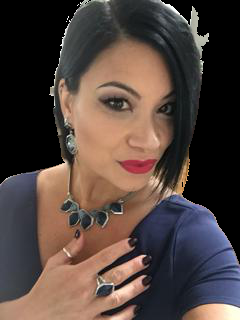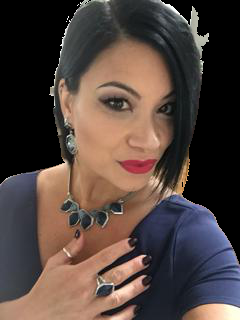, это не отловишь на предобработке